In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import cv2
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [2]:
train = 'data/train_set'
val = 'data/val_set'

In [3]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE = 32

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 9528 images belonging to 15 classes.


In [5]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(
    val,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 2382 images belonging to 15 classes.


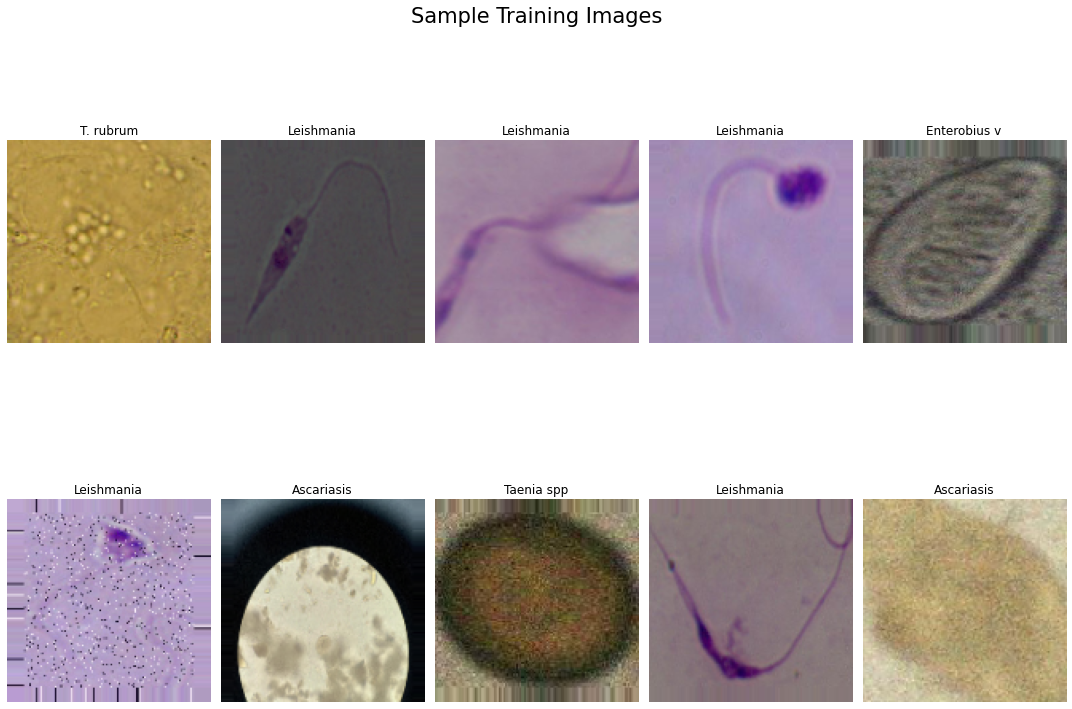

In [28]:
labels = {value: key for key, value in train_generator.class_indices.items()}

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(4):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [6]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=15, activation='softmax')
    ])
    
    return model

In [7]:
cnn_model = create_model()
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 128)     9728      
                                                                 
 activation (Activation)     (None, 124, 124, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 128)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 62, 62, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 activation_1 (Activation)   (None, 60, 60, 64)        0

In [8]:
cnn_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
history = cnn_model.fit(
    train_generator, 
    epochs=10, 
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/10
298/298 [==============================] - 510s 2s/step - loss: 1.9140 - accuracy: 0.4263 - val_loss: 2.7678 - val_accuracy: 0.1826
Epoch 2/10
298/298 [==============================] - 470s 2s/step - loss: 1.2486 - accuracy: 0.5846 - val_loss: 4.3666 - val_accuracy: 0.1830
Epoch 3/10
298/298 [==============================] - 516s 2s/step - loss: 1.0463 - accuracy: 0.6522 - val_loss: 5.8075 - val_accuracy: 0.3300
Epoch 4/10
298/298 [==============================] - 471s 2s/step - loss: 0.9223 - accuracy: 0.6904 - val_loss: 2.1025 - val_accuracy: 0.4416
Epoch 5/10
298/298 [==============================] - 463s 2s/step - loss: 0.8246 - accuracy: 0.7198 - val_loss: 2.3482 - val_accuracy: 0.4643
Epoch 6/10
298/298 [==============================] - 462s 2s/step - loss: 0.7627 - accuracy: 0.7437 - val_loss: 1.3904 - val_accuracy: 0.6171
Epoch 7/10
298/298 [==============================] - 462s 2s/step - loss: 0.7083 - accuracy: 0.7590 - val_loss: 0.6803 - val_accuracy: 0.7838

In [11]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

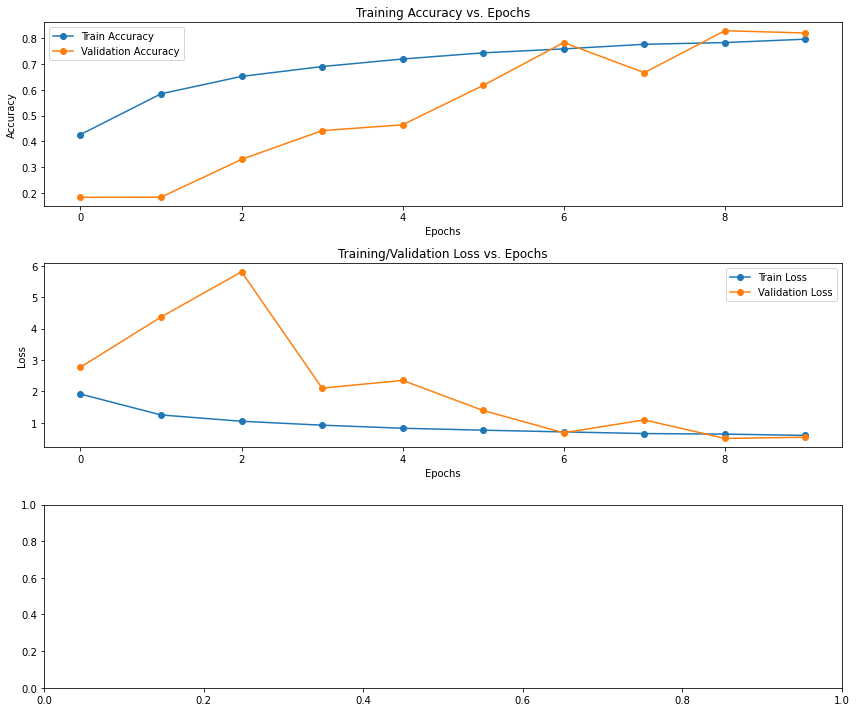

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [14]:
cnn_model.save('data/model.h5')

In [15]:
model = load_model('data/model.h5')

In [33]:
test_data_dir = 'data/test_data'

test_image_files = natsorted([
    os.path.join(test_data_dir, file) for file in os.listdir(test_data_dir) if file.endswith(('jpg', 'jpeg', 'png'))
])

predictions = []

for image_path in test_image_files:
    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 

    img_array /= 255.0

    prediction = model.predict(img_array)
    predictions.append(prediction[0]) 

predictions = np.array(predictions)

submission_df = pd.DataFrame(predictions, columns=['class_0', 'class_1', 'class_2', 'class_3', 'class_4',
                                                   'class_5', 'class_6', 'class_7', 'class_8', 'class_9',
                                                   'class_10', 'class_11', 'class_12', 'class_13', 'class_14'])

submission_df['image_name'] = [os.path.basename(file) for file in test_image_files]
submission_df = submission_df[['image_name', 'class_0', 'class_1', 'class_2', 'class_3', 
                               'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 
                               'class_10', 'class_11', 'class_12', 'class_13', 'class_14']]

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 106ms/step


1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 111ms/step


In [ ]:
submission_df.to_csv('submission.csv', index=False)
